In [1]:
#!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import make_multilabel_classification
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
#import catboost
#from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

import copy
import random
import os
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

c:\python36\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


False

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv(r'F:\coucou\AIMS\Data_Science\Competition\iX Mobile Banking\Train.csv')
test = pd.read_csv(r'F:\coucou\AIMS\Data_Science\Competition\iX Mobile Banking\Test.csv')
ss = pd.read_csv(r'F:\coucou\AIMS\Data_Science\Competition\iX Mobile Banking\SampleSubmission.csv')

In [3]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (108446, 42)
The shape of the test set is: (46477, 41)


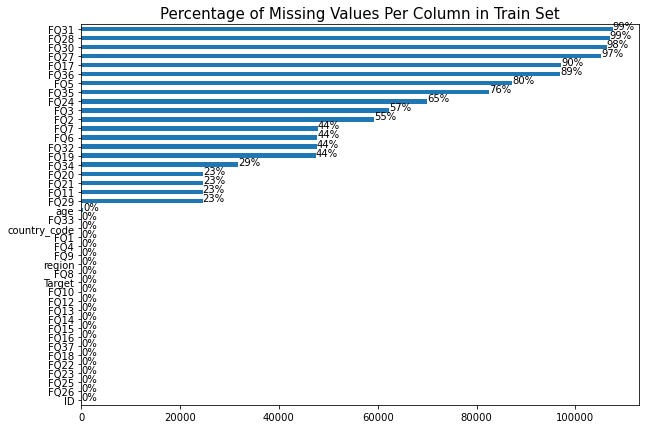

In [4]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

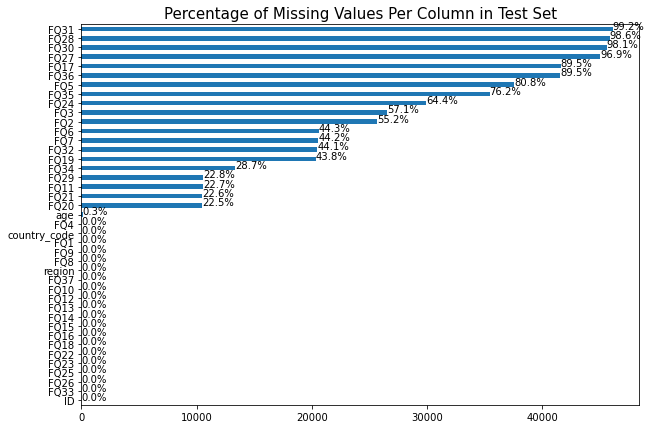

In [5]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [6]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (154923, 42)


In [7]:
# Check the column names and datatypes
all_data.head(20)

,ID,country_code,region,age,FQ1,FQ2,FQ3,FQ4,FQ5,FQ6,...,FQ27,FQ28,FQ29,FQ30,FQ31,FQ32,FQ33,FQ34,FQ37,Target
0,ID_000J8GTZ,1,6,35.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0,0.0
1,ID_000QLXZM,32,7,70.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,1.0,2.0,0,0.0
2,ID_001728I2,71,7,22.0,2,1.0,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,1,0.0
3,ID_001R7IDN,48,3,27.0,1,NaN,NaN,2,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1,0.0
4,ID_0029QKF8,25,0,79.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,2.0,1.0,1.0,1,0.0
5,ID_002OY1ME,77,0,69.0,2,NaN,NaN,2,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
6,ID_002SIOPQ,141,4,58.0,1,NaN,2.0,2,NaN,1.0,...,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0,0.0
7,ID_003CXK49,97,7,32.0,1,NaN,2.0,2,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.0
8,ID_003OKZ71,60,2,59.0,1,1.0,2.0,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,1,0.0
9,ID_004ACG4R,69,0,60.0,2,NaN,NaN,2,1.0,2.0,...,NaN,NaN,2.0,NaN,NaN,2.0,1.0,NaN,1,0.0


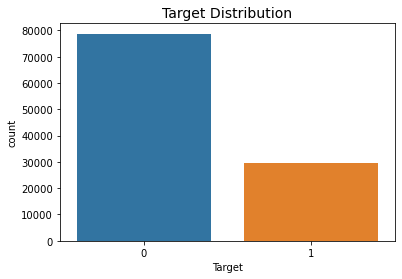

In [8]:
sns.countplot(train.Target)
plt.title('Target Distribution', fontdict={'size':14});

In [9]:
num_cols = ['country_code', 'region','age']
num_cols1=['FQ1', 'FQ2', 'FQ3', 'FQ4',
       'FQ5', 'FQ6', 'FQ7', 'FQ8', 'FQ9', 'FQ10', 'FQ11', 'FQ12', 'FQ13',
       'FQ14', 'FQ15', 'FQ16', 'FQ17', 'FQ18', 'FQ19', 'FQ20', 'FQ21', 'FQ22',
       'FQ23', 'FQ24', 'FQ35', 'FQ36', 'FQ25', 'FQ26', 'FQ27', 'FQ28', 'FQ29',
       'FQ30', 'FQ31', 'FQ32', 'FQ33', 'FQ34', 'FQ37']
#cat_cols = [col for col in all_data.columns if col not in num_cols+num_cols1+['ID','Target']]

In [10]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(0))
  elif col in num_cols1:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(3))
    
# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['Target'])].isna().sum()

FQ1             0
FQ10            0
FQ11            0
FQ12            0
FQ13            0
FQ14            0
FQ15            0
FQ16            0
FQ17            0
FQ18            0
FQ19            0
FQ2             0
FQ20            0
FQ21            0
FQ22            0
FQ23            0
FQ24            0
FQ25            0
FQ26            0
FQ27            0
FQ28            0
FQ29            0
FQ3             0
FQ30            0
FQ31            0
FQ32            0
FQ33            0
FQ34            0
FQ35            0
FQ36            0
FQ37            0
FQ4             0
FQ5             0
FQ6             0
FQ7             0
FQ8             0
FQ9             0
ID              0
age             0
country_code    0
region          0
dtype: int64

In [11]:
all_data.head()

,ID,country_code,region,age,FQ1,FQ2,FQ3,FQ4,FQ5,FQ6,...,FQ27,FQ28,FQ29,FQ30,FQ31,FQ32,FQ33,FQ34,FQ37,Target
0,ID_000J8GTZ,1,6,35.0,2,3.0,3.0,2,3.0,3.0,...,3.0,3.0,1.0,3.0,3.0,3.0,1.0,1.0,0,0.0
1,ID_000QLXZM,32,7,70.0,2,3.0,3.0,2,3.0,3.0,...,3.0,3.0,2.0,3.0,3.0,3.0,1.0,2.0,0,0.0
2,ID_001728I2,71,7,22.0,2,1.0,3.0,2,3.0,3.0,...,3.0,3.0,2.0,3.0,3.0,3.0,2.0,1.0,1,0.0
3,ID_001R7IDN,48,3,27.0,1,3.0,3.0,2,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1,0.0
4,ID_0029QKF8,25,0,79.0,2,3.0,3.0,2,3.0,3.0,...,3.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1,0.0


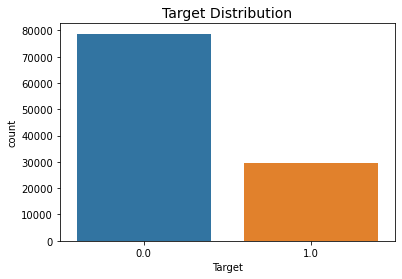

In [12]:
sns.countplot(all_data.Target)
plt.title('Target Distribution', fontdict={'size':14});

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# for reprocducibility
def seed_all(seed): 
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [15]:
seed=0
seed_all(seed)

In [16]:
seed_all(seed)
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((108446, 42), (46477, 42))

In [36]:
seed_all(seed)
# generate two class dataset
# Select main columns to be used in training
main_cols = all_data.columns.difference(['ID', 'Target'])
X = train_df[main_cols]
y = train_df.Target

# split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [37]:
# logistic regression
model = LogisticRegression()

# fit model
model.fit(X_train, y_train)

pred = model.predict(X_test)

# predict probabilities
pred_prob = model.predict_proba(X_test)


In [42]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [45]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score = roc_auc_score(y_test, pred_prob[:,1])

print(auc_score)

0.4949970306191731


In [57]:
from collections import Counter
Counter(pred)

Counter({0.0: 32534})

In [50]:
print(pred_prob)

[[0.73004098 0.26995902]
 [0.72456281 0.27543719]
 [0.73556868 0.26443132]
 ...
 [0.72865544 0.27134456]
 [0.73538123 0.26461877]
 [0.73001956 0.26998044]]


In [61]:
#print(predictions)
len(X_test)

32534

In [62]:
# Create a submission file
sub_file = ss.copy()
sub_file.Target = pred_prob

# Check the distribution of your predictions
sns.countplot(sub_file.Target);

ValueError: Length of values (32534) does not match length of index (46477)

In [54]:
set(test.ID == ss.ID)

{True}

In [28]:
print("[INFO] Creating pandas dataframe")
submission_data = {"ID":sub_file['ID'],"Target":predictions,}
submission_data_frame = pd.DataFrame(submission_data)
submission_data_frame

[INFO] Creating pandas dataframe


,ID,Target
0,ID_000YI58E,0.0
1,ID_001SP4JF,0.0
2,ID_001VOF6S,0.0
3,ID_0030LULG,0.0
4,ID_0037PZ3R,0.0
...,...,...
46472,ID_ZZYOTVBJ,0.0
46473,ID_ZZYSX122,0.0
46474,ID_ZZYXQDSD,0.0
46475,ID_ZZZH9SS4,0.0
